Simple clustering of MNIST dataset using normalized compression distance

# Open data

In [1]:
from sklearn import datasets

In [2]:
digits = datasets.load_digits()
data = digits.data
label = digits.target
classes = digits.target_names
k = len(classes)

# Reencoding data

For a perfect compressor, it would be enough to work with this initial data. However in real case settings, it is important to encode the data in a meaningful way which allows the compressor to obtain close to optimal performances.

In [3]:
import numpy as np

In [4]:
data = data > 7 # B&W - Could be done more nicely ...

In [5]:
reencoded = []
for d in data:    
    # Add end of line as in the original paper
    reencoded.append(np.append(d.reshape(8, 8), np.full((8, 1), -1), axis = 1).flatten())
data = np.array(reencoded)

# Compute pairwise distance

In [6]:
from sklearn.metrics import pairwise_distances
from distance import ncd

In [7]:
def alternate(x, y):
    """
        Concatenate two arrays alternatively
    """
    result = np.full(len(x) + len(y), 0)
    result[::2] = x
    result[1::2] = y
    return result

In [8]:
# For images we try alternate concatenation as the 
# Compression is unperfect and it actually drastically imporves
# Perfomances on short arrays like we have
distances = pairwise_distances(data, metric = ncd, n_jobs = 15, 
                               concatenate = alternate)
np.fill_diagonal(distances, 0) # As compression can create non zero distance

In [9]:
distances[:5][:, :5]

array([[0.        , 0.72072072, 0.88028169, 0.59060403, 0.64393939],
       [0.72072072, 0.        , 0.66901408, 0.59731544, 0.64393939],
       [0.88028169, 0.66901408, 0.        , 0.5033557 , 0.68309859],
       [0.59060403, 0.59731544, 0.5033557 , 0.        , 0.45637584],
       [0.64393939, 0.64393939, 0.68309859, 0.45637584, 0.        ]])

# Visualization distance

Display mean distance between labels

In [10]:
import matplotlib.pyplot as plt

In [11]:
average = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        average[i, j] = distances[label == i][:, label == j].mean()
average /= average.max()

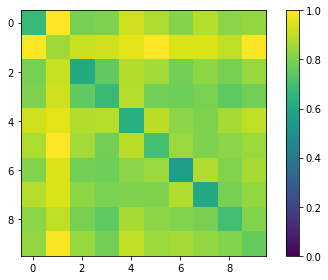

In [12]:
plt.figure()
plt.imshow(average, interpolation='nearest', vmin=0)
plt.colorbar()
plt.tight_layout()

# Clustering

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

Cluster using agglomerative based on euclidean distance

In [14]:
kmeans = KMeans(k).fit_predict(data)

Cluster using agglomerative algo on ncb distance

In [15]:
agglo = AgglomerativeClustering(k, affinity = 'precomputed', linkage = 'complete').fit_predict(distances)

# Evaluation

In [16]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

### Silhouette score

Compute silhouette score using ncd

In [17]:
print("Silhouette score for perfect clustering: {:.2f}".format(silhouette_score(distances, label, metric = 'precomputed')))
print("Silhouette score for kmeans: {:.2f}".format(silhouette_score(distances, kmeans, metric = 'precomputed')))
print("Silhouette score for agglomerative: {:.2f}".format(silhouette_score(distances, agglo, metric = 'precomputed')))

Silhouette score for perfect clustering: 0.10
Silhouette score for kmeans: 0.10
Silhouette score for agglomerative: 0.06


Compute silhouette using euclidean distance

In [18]:
print("Silhouette score for perfect clustering: {:.2f}".format(silhouette_score(data, label)))
print("Silhouette score for kmeans: {:.2f}".format(silhouette_score(data, kmeans)))
print("Silhouette score for agglomerative: {:.2f}".format(silhouette_score(data, agglo)))

Silhouette score for perfect clustering: 0.11
Silhouette score for kmeans: 0.13
Silhouette score for agglomerative: 0.01


### Adjusted Score

In [19]:
print("Adjusted Rand Index for kmeans: {:.2f}".format(adjusted_rand_score(label, kmeans)))
print("Adjusted Rand Index for agglomerative: {:.2f}".format(adjusted_rand_score(label, agglo)))

Adjusted Rand Index for kmeans: 0.62
Adjusted Rand Index for agglomerative: 0.26


In conclusion, the performances look less good with this compression. However it is interesting that it achieves non random performances. Moreover, it is important to notice that Silhouette score can be a biased measure of clusters' quality as it is relying on euclidean distance